<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png?20231008195526" alt="TU/e Logo" width="200px"/>
</p>

# Assignment 2: CNN, AutoML & Hyperparameter Optimization

**Course:** 1BM120 – Decision Making with Artificial Intelligence  
**Date:** *Q4 - 2025*  

---

## Group 3

- **Sadra Moosavi Lar**  
  ✉️ [s.s.moosavi.lar@student.tue.nl](mailto:s.s.moosavi.lar@student.tue.nl)

- **Floris van Hasselt**  
  ✉️ [f.j.p.v.hasselt@student.tue.nl](mailto:f.j.p.v.hasselt@student.tue.nl)

- **Sam Fiers**  
  ✉️ [s.s.w.fiers@student.tue.nl](mailto:s.s.w.fiers@student.tue.nl)

---

**Repository:** [GitHub – Group 3 Repo](https://github.com/sadra-hub/1BM120-decisiondecisionMakingWithAI)

---

## Description

We're helping a Dutch manufacturing company, Wefabricate, build an automated visual inspection system for their factory. They make a plastic part (called the front plate of an industrial plug) and want to detect defects like scratches, burns, or missing chunks using image classification.

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [4]:
# Set seed for reproducibility
def set_seed(seed=18):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [22]:
from support import load_dataset
from torch.utils.data import DataLoader

# Load datasets
train_dataset, test_dataset = load_dataset()

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

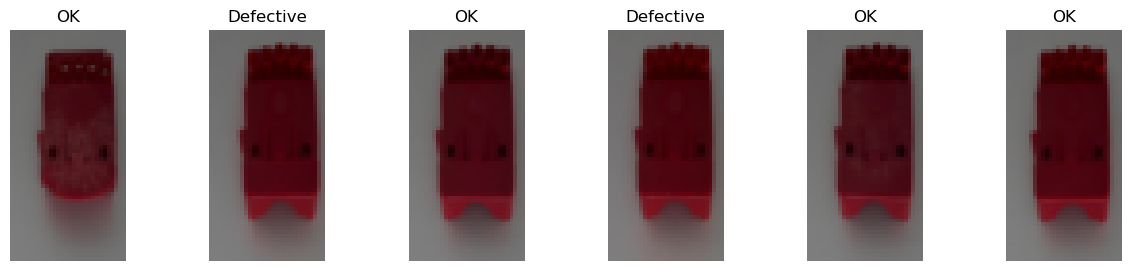

In [11]:
def show_sample_images(loader, classes=["OK", "Defective"]):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    for idx in range(6):
        img = images[idx].permute(1, 2, 0)
        axes[idx].imshow(img)
        axes[idx].set_title(classes[labels[idx].item()])
        axes[idx].axis("off")
    plt.show()

show_sample_images(train_loader)

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Output: (32, H/4, W/4)
        )

        # Compute the output size after conv layers dynamically
        dummy_input = torch.zeros(1, 3, 60, 30)
        dummy_output = self.features(dummy_input)
        flattened_size = dummy_output.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    return running_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = [], []
for epoch in range(10):
    loss, acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

Epoch 1: Loss = 0.6955, Accuracy = 0.5662
Epoch 2: Loss = 0.7201, Accuracy = 0.4853
Epoch 3: Loss = 0.6878, Accuracy = 0.5588
Epoch 4: Loss = 0.6816, Accuracy = 0.6544
Epoch 5: Loss = 0.6714, Accuracy = 0.6985
Epoch 6: Loss = 0.6676, Accuracy = 0.6471
Epoch 7: Loss = 0.6261, Accuracy = 0.7353
Epoch 8: Loss = 0.6116, Accuracy = 0.7132
Epoch 9: Loss = 0.5723, Accuracy = 0.7574
Epoch 10: Loss = 0.5562, Accuracy = 0.7279


In [16]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(test_loader.dataset)

baseline_accuracy = evaluate(model, test_loader, device)
print(f"Baseline Test Accuracy: {baseline_accuracy:.4f}")

Baseline Test Accuracy: 0.7059


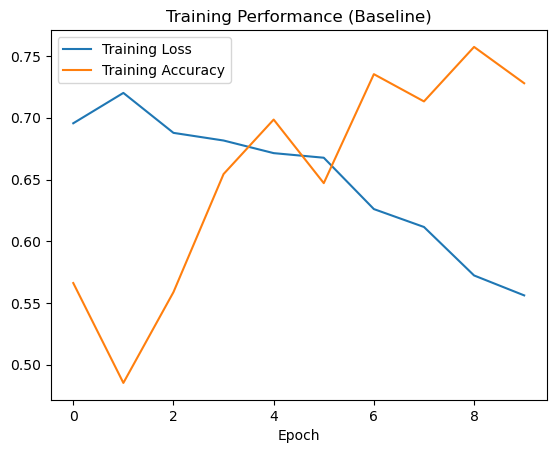

In [17]:
plt.plot(train_losses, label="Training Loss")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Performance (Baseline)")
plt.show()

In [25]:
import optuna

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    num_filters = trial.suggest_int("num_filters", 16, 64, step=16)

    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, num_filters, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(num_filters, num_filters * 2, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )

            # Dynamically determine flattened size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 3, 60, 30)  # Your image size
                dummy_out = self.features(dummy_input)
                self.flattened_size = dummy_out.view(1, -1).shape[1]

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(self.flattened_size, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 2)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x
    
    model = TunedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == "Adam" else optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    loss, acc = train(model, loader, criterion, optimizer, device)
    return acc

In [26]:
random_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
random_study.optimize(objective, n_trials=20)
print("Best hyperparameters (random):", random_study.best_params)

[I 2025-06-03 17:44:47,586] A new study created in memory with name: no-name-f0a70a14-f060-4396-988b-3c442f483c22
[I 2025-06-03 17:45:02,802] Trial 0 finished with value: 0.45588235294117646 and parameters: {'lr': 0.0004579439891161151, 'dropout': 0.6519051236850102, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 48}. Best is trial 0 with value: 0.45588235294117646.
[I 2025-06-03 17:45:17,365] Trial 1 finished with value: 0.4852941176470588 and parameters: {'lr': 0.007636210566247188, 'dropout': 0.6434943412048778, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 64}. Best is trial 1 with value: 0.4852941176470588.
[W 2025-06-03 17:45:19,758] Trial 2 failed with parameters: {'lr': 5.8938067633114045e-05, 'dropout': 0.6918923869587008, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/sadra/miniconda3/envs/1BM120_2/lib/python3.10/site-packages/optuna/study/_optimize.

KeyboardInterrupt: 

In [27]:
tpe_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
tpe_study.optimize(objective, n_trials=20)
print("Best hyperparameters (TPE):", tpe_study.best_params)

[I 2025-06-03 17:45:24,187] A new study created in memory with name: no-name-7a5c3fb4-04a7-4ce8-af1e-f5251c66c026
[I 2025-06-03 17:45:38,723] Trial 0 finished with value: 0.4852941176470588 and parameters: {'lr': 3.276218376190098e-05, 'dropout': 0.5213335081707975, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 16}. Best is trial 0 with value: 0.4852941176470588.
[W 2025-06-03 17:45:42,341] Trial 1 failed with parameters: {'lr': 0.00580977283929093, 'dropout': 0.3825679236058005, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/sadra/miniconda3/envs/1BM120_2/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/86/60m68tfx6wdfjt93m00bhrx40000gn/T/ipykernel_1792/530499252.py", line 46, in objective
    loss, acc = train(model, loader, criterion, optimizer, device)
  File "/var/folders/86/6

KeyboardInterrupt: 

In [28]:
best_params = tpe_study.best_params

# Recreate and train best model using best_params...
# Save weights
torch.save(model.state_dict(), "cnn_optimized.pth")

In [29]:
print("Baseline Accuracy:", baseline_accuracy)
print("Best Optimized Accuracy (TPE):", tpe_study.best_value)

Baseline Accuracy: 0.7058823529411765
Best Optimized Accuracy (TPE): 0.4852941176470588


In [30]:
# Save
torch.save(model.state_dict(), "model_weights.pth")

# Load
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

/var/folders/86/60m68tfx6wdfjt93m00bhrx40000gn/T/ipykernel_1792/1010362251.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weight

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)